# 1 - Imports

In [1]:
from IPython.display import Audio

import librosa
import librosa.display as ld
import numpy as np
import matplotlib.pyplot as plt
import pickle

# 2 - Tests

## 2.1 - Listen to the audio

In [2]:
audio_path = '/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCeleb2/dev/id00012/21Uxsk56VDQ/00001.m4a'

Audio(audio_path)

## 2.2 Load the audio

Notice that the original sampling rate is obtained if sampling_rate is not defined.

In [3]:
samples, sampling_rate = librosa.load(
    path = audio_path,
    mono = True,
)

samples_num = len(samples)
length_secs = samples_num / sampling_rate

print(f"samples_num: {samples_num}")
print(f"sampling_rate: {sampling_rate}")
print(f"length_secs: {length_secs}")

/home/usuaris/veu/federico.costa/.conda/envs/DASV/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


samples_num: 207447
sampling_rate: 22050
length_secs: 9.408027210884354


We can load the audio with an especific sampling_rate. In this case librosa automatically resamples it.

In [4]:
samples, sampling_rate = librosa.load(
    path = audio_path,
    sr = 16000,
    mono = True,
)

samples_num = len(samples)
length_secs = samples_num / sampling_rate

print(f"samples_num: {samples_num}")
print(f"sampling_rate: {sampling_rate}")
print(f"length_secs: {length_secs}")

samples_num: 150528
sampling_rate: 16000
length_secs: 9.408


/home/usuaris/veu/federico.costa/.conda/envs/DASV/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


## 2.3 - Spectrogram

#### Pre-emphasis

In [5]:
preem_coef = 0.97
samples *= 32768 # no idea why!

samples[1:] = samples[1:] - preem_coef * samples[:-1]
samples[0] *= (1 - preem_coef)

#### stft

In [6]:
n_fft_secs = 0.032
hop_length_secs = 0.010
win_length_secs = 0.023

n_fft = int(n_fft_secs * sampling_rate)
hop_length = int(hop_length_secs * sampling_rate)
win_length = int(win_length_secs * sampling_rate)

print(f"n_fft: {n_fft}")
print(f"hop_length: {hop_length}")
print(f"win_length: {win_length}")

n_fft: 512
hop_length: 160
win_length: 368


Using stft we should get [((len(samples) - n_fft) / hop_length) + 1] frames and [n_fft / 2 + 1] frequency bins

In [7]:
D = librosa.stft(
    samples, 
    n_fft = n_fft, 
    hop_length = hop_length,
    win_length = win_length, 
    window = 'hamming', 
    center = False,
    )

calculated_frames = ((len(samples) - n_fft) / hop_length) + 1
calculated_freq_bins = n_fft / 2 + 1

print(f"calculated_frames {calculated_frames}")
print(f"calculated_freq_bins {calculated_freq_bins}")
print(f"D.shape {D.shape}")

calculated_frames 938.6
calculated_freq_bins 257.0
D.shape (257, 938)


In [8]:
n_mels = 80

magnitudes = np.abs(D)
low_freq = 0
high_freq = sampling_rate / 2

mel_spectrogram = librosa.feature.melspectrogram(
    S = magnitudes, 
    sr = sampling_rate, 
    n_mels = n_mels, 
    fmin = low_freq, 
    fmax = high_freq, 
    norm = None,
    )

log_mel_spectrogram = np.log(np.maximum(1, mel_spectrogram))

log_mel_spectrogram.shape

(80, 938)

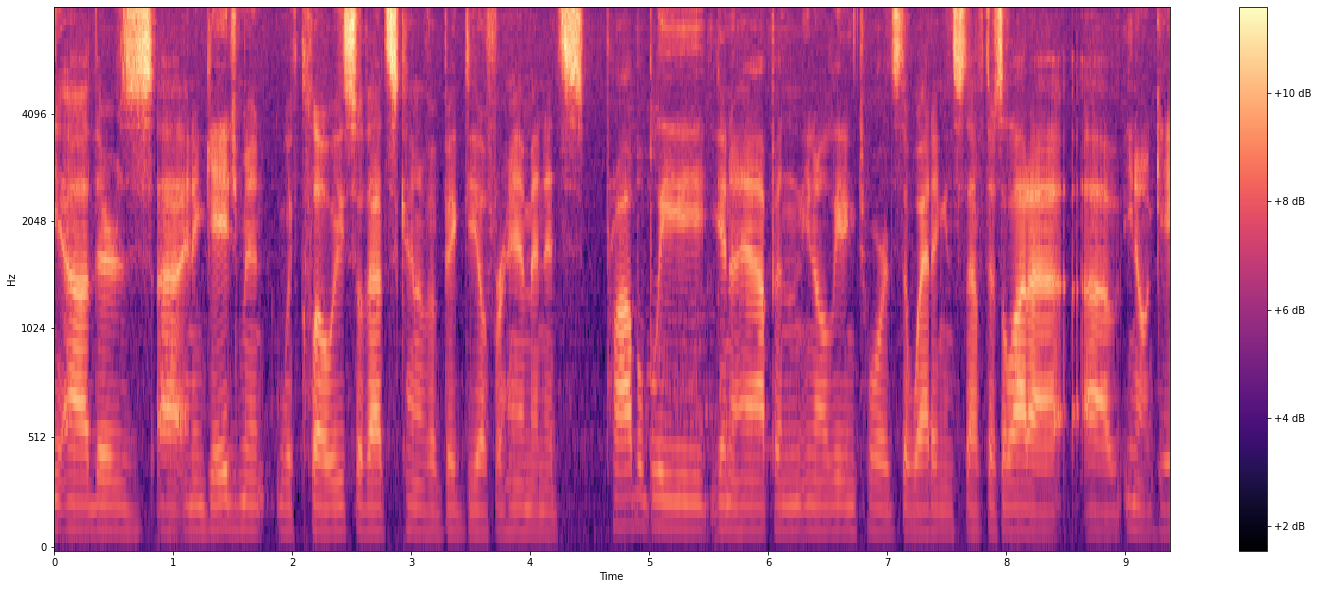

In [9]:
plt.figure(figsize=(25, 10))

librosa.display.specshow(
    data = log_mel_spectrogram, 
    sr = sampling_rate,
    hop_length = hop_length,
    n_fft = n_fft,
    win_length = win_length,
    x_axis = "time",
    y_axis = "mel", 
    
    )

plt.colorbar(format="%+2.f dB")
plt.show()

#### Finally, this matrix will be saved together with all config parameters in a .pickle

## 2.3 - Spectrogram load

Now we have the spectrogram saved in a .pickle.

When training the model we will need to load it and crop a window_size seconds piece of the audio at random.

In [14]:
window_size = 2.5
pickle_path = '/home/usuaris/veussd/DATABASES/VoxCeleb/VoxCeleb2/dev/id00012/21Uxsk56VDQ/00001.pickle'

with open(pickle_path, 'rb') as pickle_file:
    features_dict = pickle.load(pickle_file)

    features = features_dict["features"]
    features_settings = features_dict["settings"]

In [15]:
log_mel_spectrogram = features
log_mel_spectrogram.shape

(80, 939)

In [12]:
estimated_frames = log_mel_spectrogram.shape[1]
estimated_samples = (estimated_frames - 1) * hop_length + n_fft
estimated_audio_length_secs = estimated_samples / sampling_rate
estimated_frames_1_sec = estimated_frames / estimated_audio_length_secs 
random_crop_size_frames = window_size * estimated_frames_1_sec
random_crop_size_frames

249.41501808125932

In [13]:
estimated_frames_1_sec

99.76600723250372

In [16]:
features_settings

Namespace(audio_paths_file_folder='./feature_extractor/', audio_paths_file_name='voxceleb_2_dev_feature_extractor_paths.lst', log_file_folder='./logs', log_file_name='feature_extractor_voxceleb_2_dev.log', sampling_rate=16000, n_fft_secs=0.023, window='hamming', win_length_secs=0.023, hop_length_secs=0.01, pre_emph_coef=0.97, n_mels=80, overwrite=True, verbose=False, audio_paths_file_path='./feature_extractor/voxceleb_2_dev_feature_extractor_paths.lst')